In [1]:
import os
from os import path
from datetime import datetime, timedelta, date
import random
import pytz

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import nbinom
from scipy.stats import poisson
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib.animation import FuncAnimation

import seaborn as sns

import networkx as nx

In [2]:
title = "WKU"
data_folder = "./data"
output_folder = "./output"
sim_id = 165
sim_tz = "Asia/Shanghai"
time0 = 'Nov 20 2023 9:00AM'
time1 = 'Dec 4 2023 12:00PM'
time_step_min = 30

use_new_id_schema = True   

# Print warning messages to the console when parsing data
print_data_warnings = False

discard_reinfections = True

# Default contact time for transmissions that are missing an associated contact event
def_contact_time = 10

# Time delta for plots in seconds
time_delta_sec = 60 * time_step_min

if not path.exists(output_folder):
    os.makedirs(output_folder)

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)

if time0 and time1:
    obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))
else:
    obs_date0 = None
    obs_date1 = None

In [3]:
# Data parsing functions

# It calculates the weights in minutes
def get_contact_list(events, infections):
    mili_to_seconds = 60 * 1000
    
    contacts = events[events["type"] == "contact"]

    node0 = contacts.user_id.values
    node1 = contacts.peer_id.values
    length = contacts.contact_length.values

    clist = {}
    for id0, id1, l01 in zip(node0, node1, length):
        n0 = user_index[id0]
        n1 = -1
        if use_new_id_schema:
            if id1 in user_index:
                n1 = user_index[id1]
            elif print_data_warnings:
                print("Cannot find peer", id1)
        else:
            if id1 in p2pToId:
                n1 = user_index[p2pToId[id1]]
            elif print_data_warnings:
                print("Cannot find peer", id1)
    
        if -1 < n1:
            if n0 < n1:
                p01 = (n0, n1)
            else:
                p01 = (n1, n0)
            if p01 in clist:
                c = clist[p01]
            else: 
                c = 0
            
            clist[p01] = c + round(l01 / mili_to_seconds)

    for p in clist:
        clist[p] /= 2
    
    # Adding contacts from transmissions if they are not registered as contacts already
    for (n0, n1) in infections:
        if n0 < n1:
            p01 = (n0, n1)
        else:
            p01 = (n1, n0)
        if not p01 in clist:
            clist[p01] = def_contact_time
            if print_data_warnings: print("Cannot find contact between", n0, "and", n1)            

    return clist

def get_infection_list(events):
    infections = events[(events["type"] == "infection")]
    
    ilist = []
    itimes = {}
    infected = infections.user_id.values
    peers = infections.inf.values
    timestamp = infections.time.values
    for id1, peer0, ts in zip(infected, peers, timestamp):
        n1 = user_index[id1]
            
        if "PEER" in peer0:
            if use_new_id_schema:
                # New schema
                id0 = int(peer0[peer0.index("[") + 1:peer0.index(":")])
                if id0 in user_index:
                    n0 = user_index[id0]                    
                    add_infection = True
                    for e in ilist:
                        if e[1] == n1:
                            if discard_reinfections:
                                add_infection = False
                                break
                            pid0 = index_user[e[0]]
                            ts0 = itimes[(pid0, id1)]
                            if abs(ts - ts0) <= time_delta_sec:
                                add_infection = False
                                if print_data_warnings:
                                    if pid0 == id0:
                                        print("Duplicated infection:", id1, "was already infected by", id0, "in the last", time_step_min, "minutes")
                                    else:
                                        print("Multiple infection:", id1, "is being infected by", id0, "but was already infected by", pid0, "in the last", time_step_min, "minutes")
                                break    

                    if add_infection: 
                        ilist += [(n0, n1)]
                        itimes[(id0, id1)] = ts
                elif print_data_warnings:
                    print("Cannot find peer", id0)                    
            else:    
                # Old schema (sims before 2022): p2p id is in the infection column
                p2p0 = peer0[peer0.index("[") + 1:peer0.index(":")]
                if p2p0 in p2pToId:
                    id0 = p2pToId[p2p0]
                    if id0 in user_index:
                        n0 = user_index[id0]
                        if not (n0, n1) in ilist:                        
                            ilist += [(n0, n1)]
                        elif print_data_warnings:
                            print("Duplicated infection", id0, id1)  
                elif print_data_warnings:
                    print("Cannot find peer", p2p0)                        
            
    return ilist 

def get_node_state(events, state0 = None):    
    if state0 == None:
         state = [0] * len(users)
    else:            
        state = state0

    inf = events[events["type"] == "infection"]
    infMap = pd.Series(inf.inf.values, index=inf.user_id).to_dict()
    for kid in infMap:
        src = infMap[kid]
        idx = user_index[kid]
        if "CASE0" in src:
            state[idx] = 1
        if "PEER" in src:
            state[idx] = 2
            id0 = int(src[5:].split(":")[0])
            idx0 = user_index[id0]       
            if state[idx0] == 0:
                state[idx0] = 1
                if print_data_warnings:
                    print("Infecting peer did not have correct state", idx0)

    out = events[events["type"] == "outcome"]
    outMap = pd.Series(out.out.values, index=out.user_id).to_dict()
    for kid in outMap:
        out = outMap[kid]
        idx = user_index[kid]
        if out == "DEAD":
            state[idx] = 3
        if out == "RECOVERED":
            state[idx] = 4
        if out == "VACCINATED":
            state[idx] = 5
    
    return state

In [4]:
# Some utilities

# https://stackoverflow.com/a/48938464
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [5]:
# Load participants and histories

all_users = pd.read_csv(path.join(data_folder, "participants.csv"), low_memory=False) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"), low_memory=False)

users = all_users[all_users["sim_id"] == sim_id]
users['random_id'] = users['random_id'].astype(str).str.zfill(4)

events = all_events[all_events["sim_id"] == sim_id]
events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)
events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()
        
user_index = {}
index_user = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    index_user[idx] = kid
    idx += 1

# Get list of infections and contacts, needed to construct the networkx graph
state = get_node_state(events)
infections = get_infection_list(events)
contacts = get_contact_list(events, infections)

# Round min and max times to the hour
min_time = min(events['time'])
max_time = max(events['time'])
first_date = hour_rounder(datetime.fromtimestamp(min_time, tz=timezone))
last_date = hour_rounder(datetime.fromtimestamp(max_time, tz=timezone))
min_time = datetime.timestamp(first_date)
max_time = datetime.timestamp(last_date)

print("First event:", first_date)
print("Last event :", last_date)

if time0 and time1:
    print("Start time:", datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    print("End time:", datetime.strptime(time1, '%b %d %Y %I:%M%p'))

print(first_date.tzinfo)

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

# Set a random seed for reproducibility
random_seed = 32
random.seed(random_seed)

First event: 2023-11-19 15:00:00+08:00
Last event : 2023-12-05 16:00:00+08:00
Start time: 2023-11-20 09:00:00
End time: 2023-12-04 12:00:00
Asia/Shanghai
794
794
794
794


In [6]:
min_total_contact_time = 5  # at least this total time (in minutes) over the two weeks to be defined as in contact
min_total_contact_count = 1 # nodes must have at least this number of edges with other nodes to be kept

# Create the network, skipping edges between nodes that spend less than min_contact_time
# in contact during the entire sim
def create_contact_network(contacts, state, minw=0):
    nodes = [i for i in range(0, len(user_index))]
    edges = []
    weights = []    
    if 0 < len(contacts):
        for p in contacts:
            n0 = p[0]
            n1 = p[1]
            w = contacts[p]            
            if minw < w:
                edges += [(n0, n1)]
                weights += [w]
    
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_weighted_edges_from([(edges[i][0], edges[i][1], weights[i]) for i in range(len(edges))])
    
    return g

def remove_nodes_with_less_edges(G, k):
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < k]
    G.remove_nodes_from(nodes_to_remove)

G = create_contact_network(contacts, state, min_total_contact_time)

print(len(G.nodes()), len(G.edges()))

remove_nodes_with_less_edges(G, min_total_contact_count)
print(len(G.nodes()), len(G.edges()))

G.remove_nodes_from(list(nx.isolates(G)))
print(len(G.nodes()), len(G.edges()))

794 1802
474 1802
474 1802


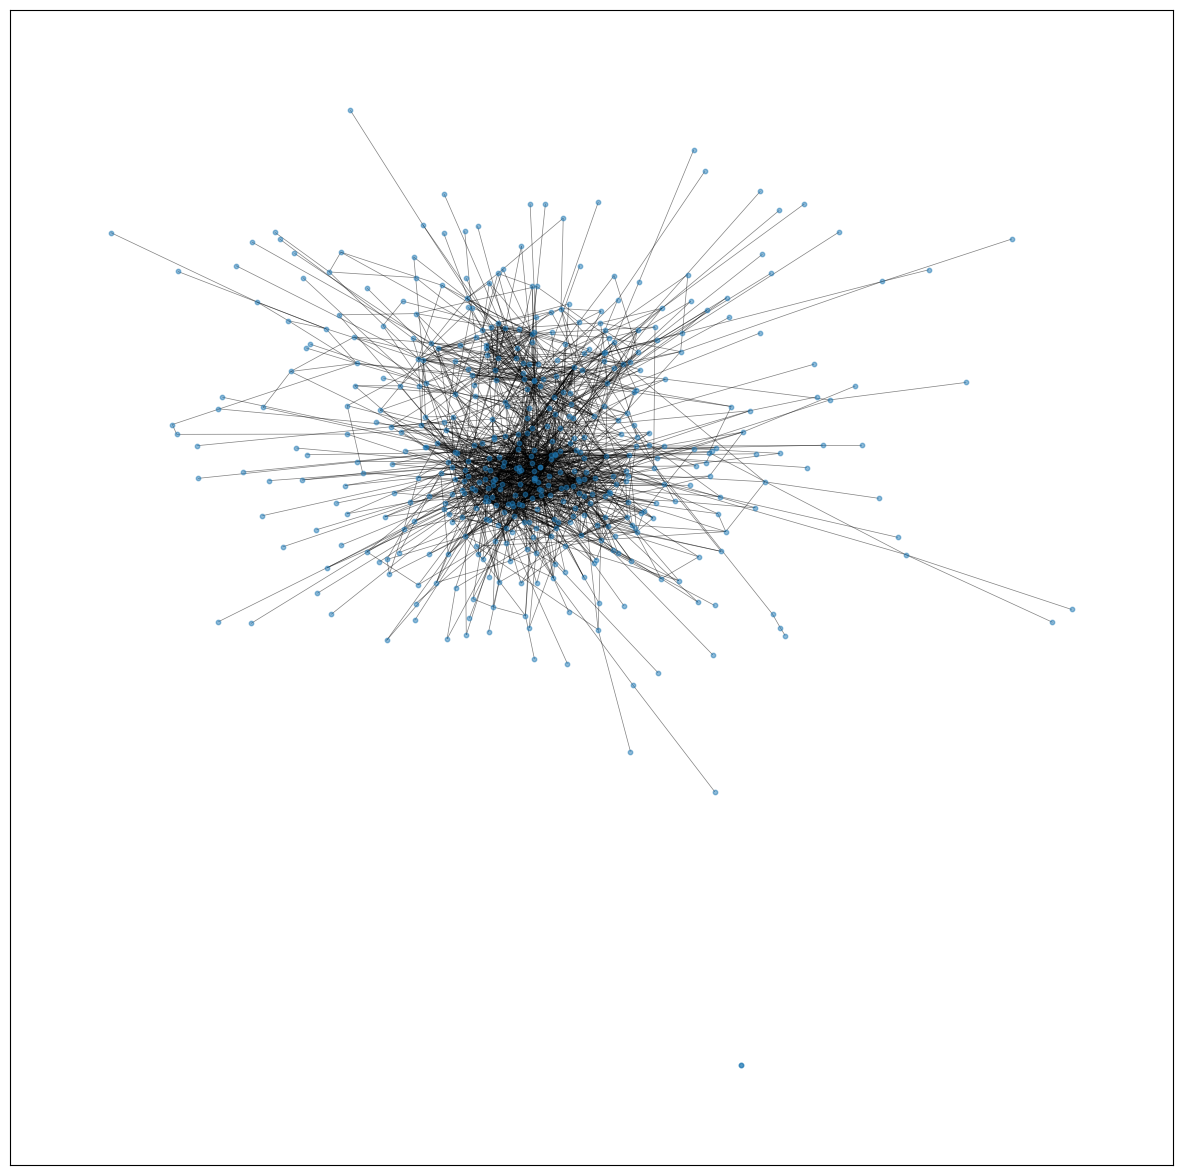

In [7]:
# Plot a basic spring layour\t of the entire network
pos = nx.spring_layout(G, seed=random_seed)
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, pos, with_labels=False, node_size=10, width=0.5, alpha=0.5)
plt.show()

In [8]:
# If the Graph has more than one component, this will return False:
print("Network is connected", nx.is_connected(G))

components = nx.connected_components(G)

subgraphs = [G.subgraph(c) for c in components]
for sg in subgraphs:
    print(len(sg.nodes()), len(sg.edges()))

# Calculate the largest connected component subgraph:
G = sorted(subgraphs, key=lambda x: len(x))[-1]

Network is connected False
472 1801
2 1


In [9]:
print("Network density:", nx.density(G))
print("Network diameter:", nx.diameter(G))

Network density: 0.016202454208499768
Network diameter: 9


In [10]:
# Calculatinf the node positions for the largest connected component
Gpos = nx.spring_layout(G, seed=random_seed)

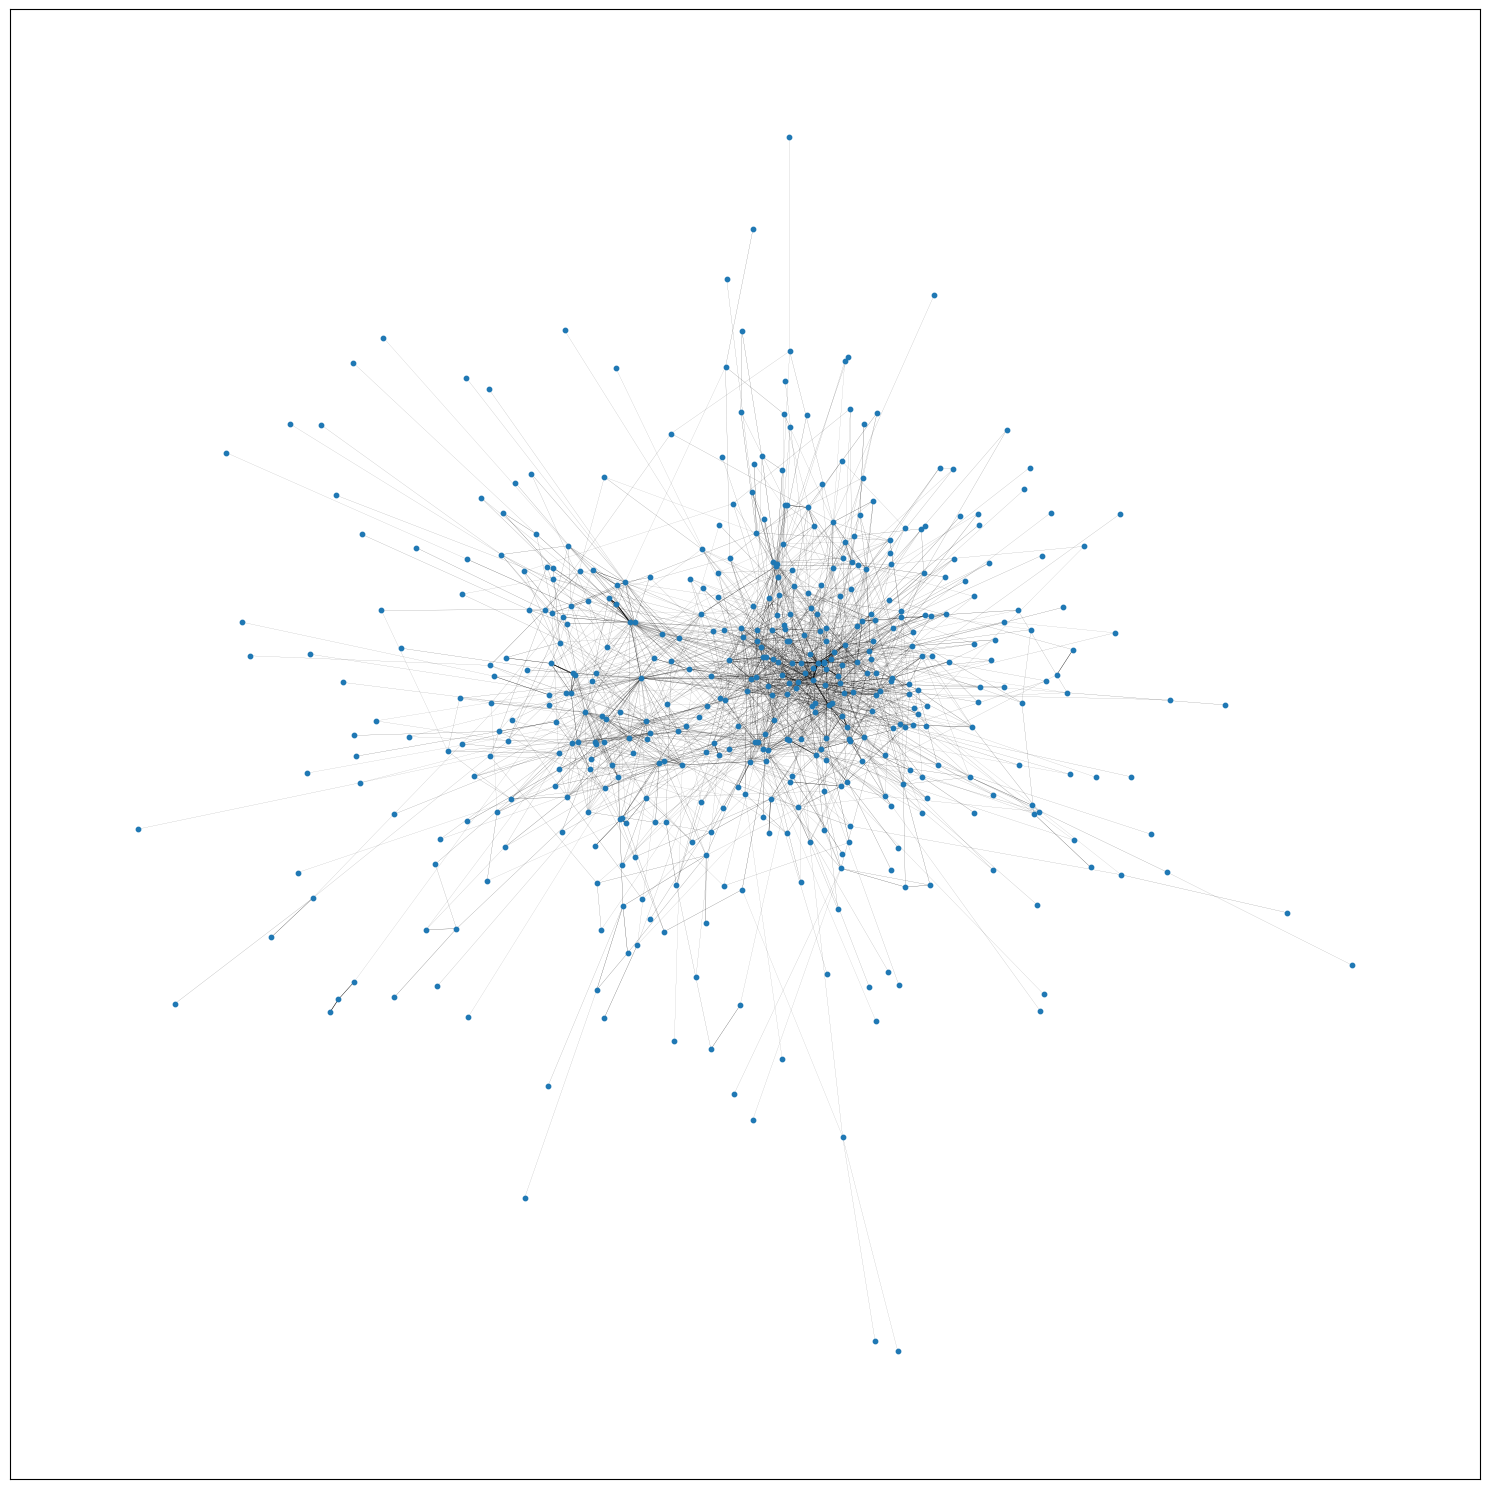

In [11]:
plt.figure(figsize=(15, 15))

weights = list(nx.get_edge_attributes(G, 'weight').values())
wmin = np.min(weights)/2
wmax = np.max(weights)
edge_weights = [pow((w - wmin)/(wmax-wmin), 0.35) for w in weights] 

nx.draw_networkx(G, Gpos, with_labels=False, node_size=10, width=edge_weights, alpha=1)
plt.tight_layout()
plt.savefig(path.join(output_folder, 'network.png'))
plt.show()

From https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

The final structural calculation you will make on this network concerns the concept of triadic closure. Triadic closure supposes that if two people know the same person, they are likely to know each other. If Fox knows both Fell and Whitehead, then Fell and Whitehead may very well know each other, completing a triangle in the visualization of three edges connecting Fox, Fell, and Whitehead. The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.

One way of measuring triadic closure is called clustering coefficient because of this clustering tendency, but the structural network measure you will learn is known as transitivity.10 Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one person (Fox) knows two people (Fell and Whitehead). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. Remember, measurements like transitivity and density concern likelihoods rather than certainties. All the outputs of your Python script must be interpreted, like any other object of research. Transitivity allows you a way of thinking about all the relationships in your graph that may exist but currently do not.

You can calculate transitivity in one line, the same way you calculated density:
    

In [12]:
triadic_closure = nx.transitivity(G)
print(f"Triadic closure = {triadic_closure:.2f}")

Triadic closure = 0.19


## Community detection

11


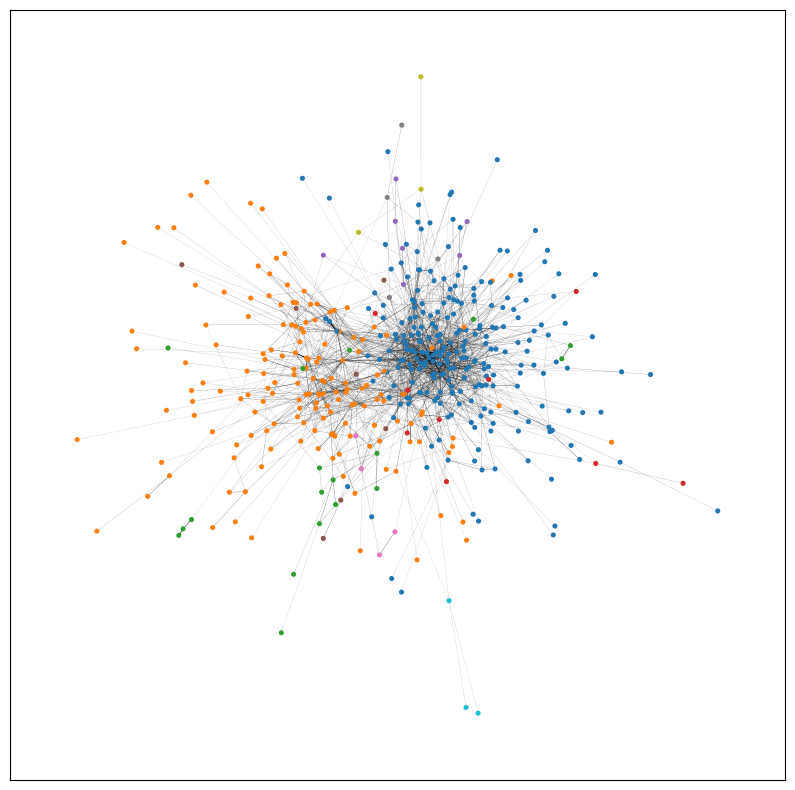

In [13]:
# resolution If resolution is less than 1, modularity favors larger communities. Greater than 1 favors smaller communities.
communities = nx.community.greedy_modularity_communities(G, resolution=0.7)

node_groups = []
for com in communities:
    node_groups.append(list(com)) 
print(len(node_groups))

palette = sns.color_palette(palette=None, n_colors=len(node_groups))

color_map = []
for node in G:
    for gr in node_groups:
        if node in gr:
            idx = node_groups.index(gr)
            color_map.append(palette[idx])
    
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, Gpos, node_color=color_map, with_labels=False, node_size=7, width=edge_weights, alpha=1)
plt.show()

17


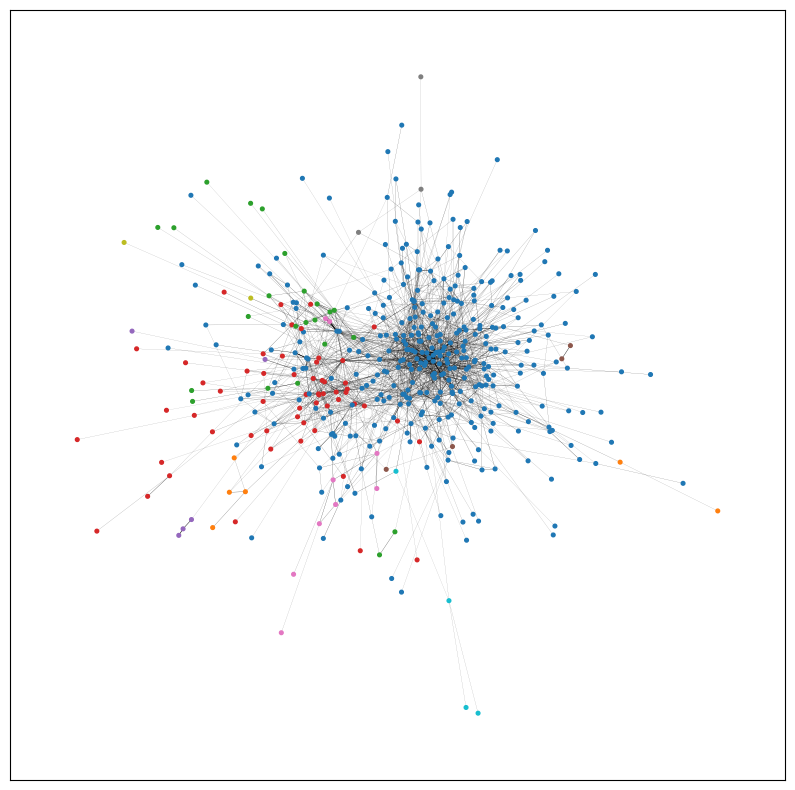

In [14]:
communities = nx.community.asyn_lpa_communities(G)

node_groups = []
for com in communities:
    node_groups.append(list(com)) 
print(len(node_groups))

palette = sns.color_palette(palette=None, n_colors=len(node_groups))

color_map = []
for node in G:
    for gr in node_groups:
        if node in gr:
            idx = node_groups.index(gr)
            color_map.append(palette[idx])
        
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, Gpos, node_color=color_map, with_labels=False, node_size=7, width=edge_weights, alpha=1)
plt.show()

## Degree distribution

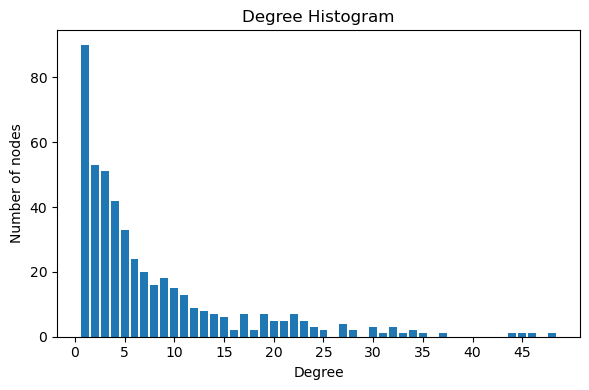

In [15]:
# Calculate degree distribution
degrees = [degree for node, degree in G.degree()]
degree_distribution = {}
for degree in degrees:
    if degree in degree_distribution:
        degree_distribution[degree] += 1
    else:
        degree_distribution[degree] = 1

# Plot the degree histogram
plt.figure(figsize=(6, 4))
plt.bar(degree_distribution.keys(), degree_distribution.values())

plt.title("Degree Histogram")
plt.ylabel("Number of nodes")
plt.xlabel("Degree")
plt.xticks(range(0, np.max(degrees), 5))
plt.tight_layout()
plt.savefig(path.join(output_folder, 'degree_hist.png'))
plt.show()

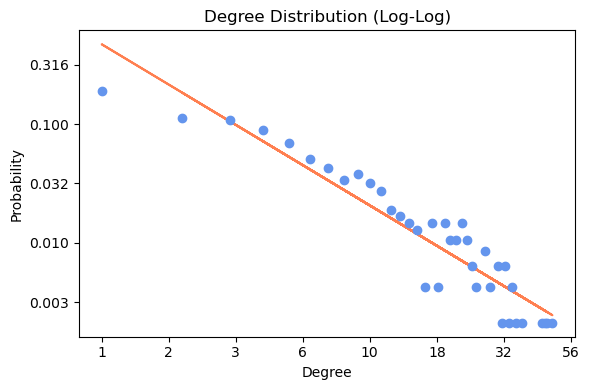

In [16]:
from matplotlib.ticker import FuncFormatter

x = np.log10(np.array(list(degree_distribution.keys())))
y = np.log10(np.array(list(degree_distribution.values())) / G.number_of_nodes())

# Perform linear regression and reate regression line
slope, intercept = np.polyfit(x, y, 1)
yreg = slope * x + intercept

def power_formatter_y(y, pos):
    return f'{10 ** y:.3f}'

def power_formatter_x(x, pos):
    return f'{round(10 ** x)}'

plt.figure(figsize=(6, 4))
plt.plot(x, yreg, color='coral', zorder=1)
plt.scatter(x, y, color='cornflowerblue', zorder=2)
plt.title("Degree Distribution (Log-Log)")
plt.ylabel("Probability")
plt.xlabel("Degree")
plt.gca().yaxis.set_major_formatter(FuncFormatter(power_formatter_y))
plt.gca().xaxis.set_major_formatter(FuncFormatter(power_formatter_x))
plt.tight_layout()
plt.savefig(path.join(output_folder, 'degree_dist_loglog.png'))
plt.show()

## Centrality measures

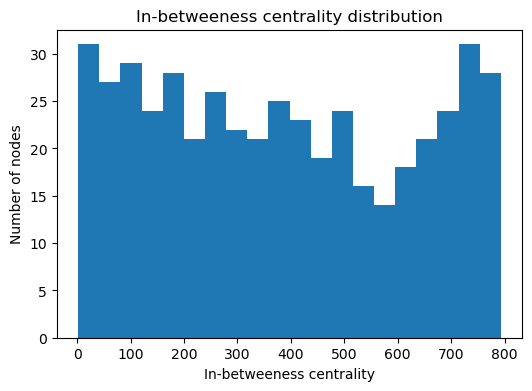

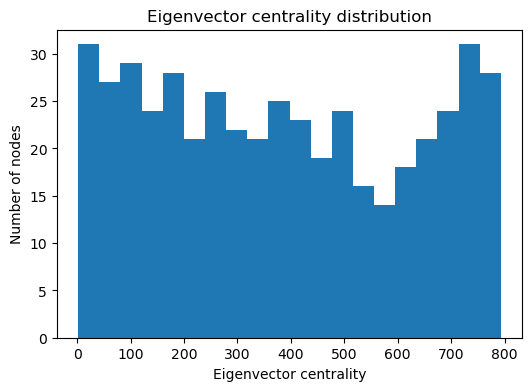

In [17]:
# This function plots the histogram for a list of values
def plot_hist_values(values, xlabel, ylabel, title, nbins=20, size=(6, 4)):
    plt.figure(figsize=size)
    plt.hist(values, bins=nbins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

betweenness_centrality = list(nx.betweenness_centrality(G)) # Run betweenness centrality
eigenvector_centrality = list(nx.eigenvector_centrality(G)) # Run eigenvector centrality
plot_hist_values(betweenness_centrality, 'In-betweeness centrality', 'Number of nodes', 'In-betweeness centrality distribution')
plot_hist_values(eigenvector_centrality, 'Eigenvector centrality', 'Number of nodes', 'Eigenvector centrality distribution')

In [18]:
def color_graph_by_attribute(G, pos, attrib, title, cmap=plt.cm.Oranges):
    # Map attrib values to colors using a colormap
    # Here, we use the 'viridis' colormap, but you can choose others like 'plasma', 'inferno', etc.
    colors = cmap(attrib)
    # Plot the graph
    plt.figure(figsize=(10, 10))  # Set the figure size|
    nx.draw_networkx(G, pos, node_color=attrib, cmap=cmap, with_labels=False, node_size=7, width=edge_weights, alpha=1)
    # plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Oranges), label='Eigenvector Centrality', norm=norm)
    plt.title(title)
    plt.show()

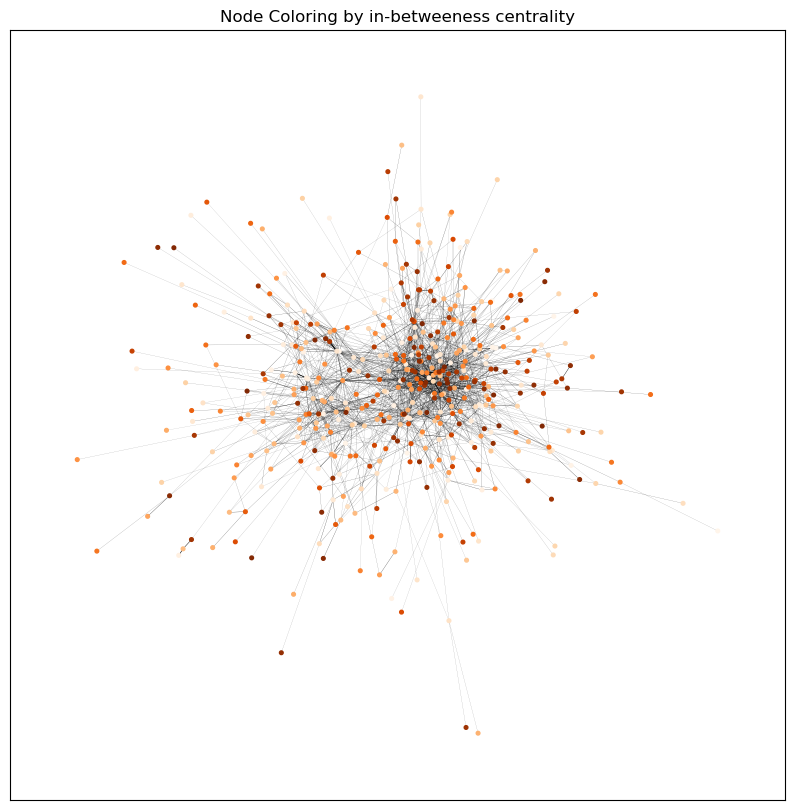

In [19]:
color_graph_by_attribute(G, Gpos, betweenness_centrality, 'Node Coloring by in-betweeness centrality')

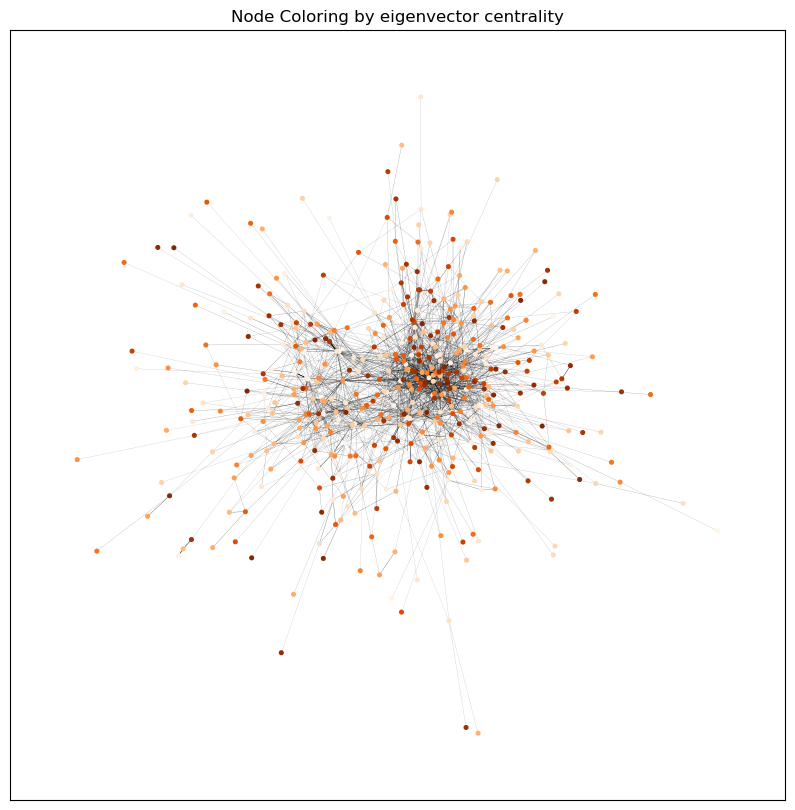

In [20]:
color_graph_by_attribute(G, Gpos, eigenvector_centrality, 'Node Coloring by eigenvector centrality')

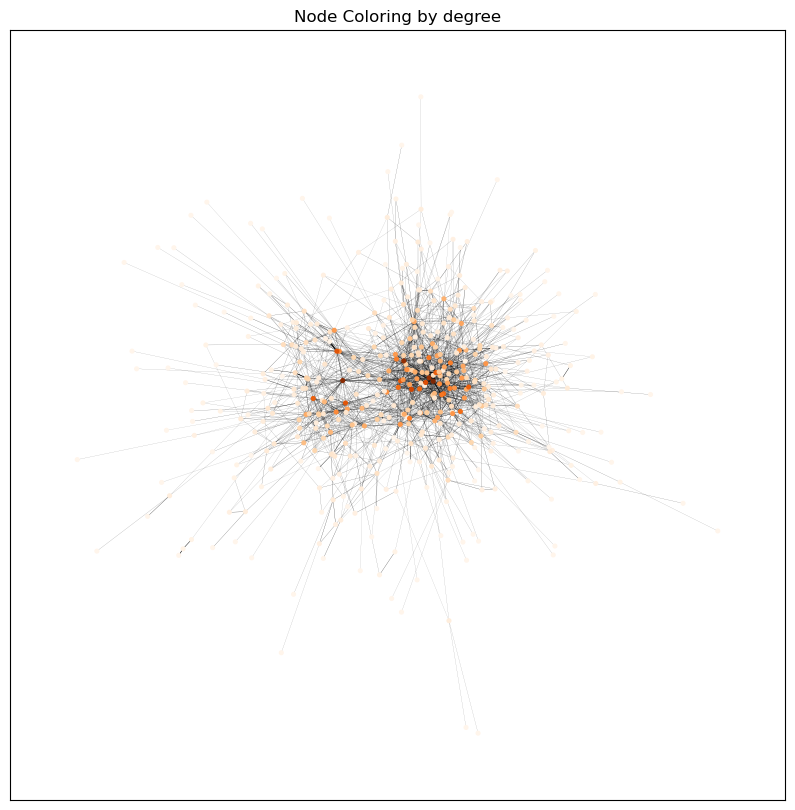

In [21]:
color_graph_by_attribute(G, Gpos, degrees, 'Node Coloring by degree')

## Animation of network spread on network

In [22]:
# Generate the state of all nodes in G for each frame of the animation

if obs_date0 and obs_date1:
    tmin = datetime.timestamp(obs_date0)
    tmax = datetime.timestamp(obs_date1)
else:
    tmin = min_time
    tmax = max_time
    
t = tmin
frame = 0
all_state = []
tstate = None
print('Calculating the states of each frame...')
while t <= tmax:
    t0 = t
    t += time_delta_sec
    td = datetime.fromtimestamp(t, tz=timezone)
    
    # We want to include contact and infection events that either started or ended between t0 and t
    condition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    tevents = events[condition]
    tstate = get_node_state(tevents, tstate)

    fstate = [tstate[idx] for idx in list(G.nodes())]
    all_state.append(fstate)
    frame += 1
print('Done')

num_frames = len(all_state)
print(f'Calculated states for {num_frames} frames')

Calculating the states of each frame...
Done
Calculated states for 679 frames


Generating and saving animation (frames=679)...
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 

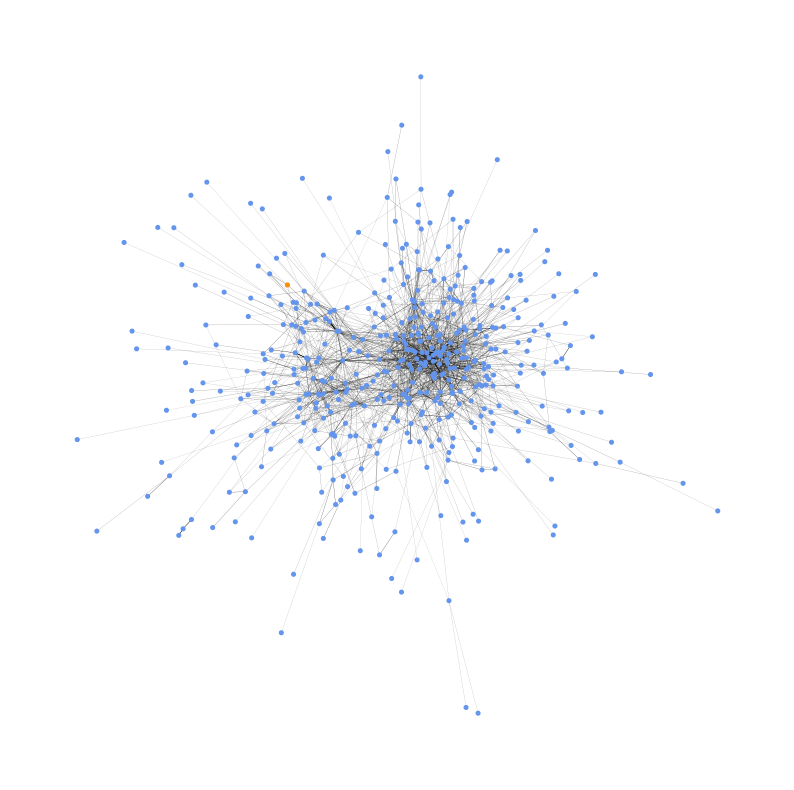

In [23]:
# Coded state:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
state_color = {0: clr.to_hex("cornflowerblue"),  # Susceptible
               1: clr.to_hex("darkorange"),      # Infected (index case)
               2: clr.to_hex("darkorange"),      # Infected (from someone else)
               3: clr.to_hex("darkgrey"),        # Dead 
               4: clr.to_hex("mediumseagreen"),  # Recovered 
               5: clr.to_hex("darkorchid")       # Vaccinated 
               } 

# Function to update the colors during the sim
def update_colors(frame):
    colors = [state_color[s] for s in all_state[frame]]
    print(frame, end=' ')
    
    # Redraw the graph with updated colors
    ax.clear() # Clear the previous drawing
    nx.draw(G, Gpos, ax=ax, node_color=colors, with_labels=False, node_size=7, width=edge_weights, alpha=1)
    
# Setup plot
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G, Gpos, ax=ax, node_color=state_color[0], with_labels=False, node_size=7, width=edge_weights, alpha=1)

# Create animation
print(f'Generating and saving animation (frames={num_frames})...')
ani = FuncAnimation(fig, update_colors, frames=num_frames, interval=33)

# Save as mp4 file
ani.save(path.join(output_folder, 'graph_animation.mp4'), writer='ffmpeg')
print('\nDone')

In [24]:
# To display in a Jupyter notebook

# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 25

# from IPython.display import HTML
# print(f'Generating embedded animation (frames={num_frames})...')
# HTML(ani.to_jshtml())
# print('\nDone')

## Correlation between action and demographic variables

In [25]:
user_survey = pd.read_csv(path.join(data_folder, "survey.csv"))

# Remove entries with invalid ID
user_survey = user_survey[user_survey['user_id'].isin(users['random_id'])]

question1 = "Public health officials should have the power to order people into quarantine during COVID-19 outbreaks"
question2 = "If someone is given a quarantine order by a public health official, they should follow it no matter what else is going on in their life at work or home"
question3 = "If I go into quarantine, my family, friends, and community will be protected from getting COVID-19"

demo_vars = ['q1_response', 'q2_response', 'q3_response']
action_vars = ['quarantine_yes', 'quarantine_no', 'quarantine_ratio', 'wear_mask', 'num_contacts']
attribs = action_vars + demo_vars

In [26]:
user_survey

,user_id,question1,question2,question3
1,5314,4,4,4
3,1956,4,3,4
4,7925,4,4,4
6,9659,5,5,5
7,4137,5,5,1
...,...,...,...,...
569,0076,5,5,5
573,0525,5,5,5
574,4853,4,3,4
577,8429,3,3,3


In [27]:
qy_values = []
qn_values = []
qr_values = []
wm_values = []
q1_values = []
q2_values = []
q3_values = []

qy_dict = {}
qn_dict = {}
qr_dict = {}
wm_dict = {}
q1_dict = {}
q2_dict = {}
q3_dict = {}

for idx in G.nodes():
    uid = users['id'][idx]
    rid = users['random_id'][idx]
    
    user_events = events[events['user_id'] == uid]
    qy_ev = user_events[user_events['inf'] == 'quarantine']
    qn_ev = user_events[user_events['inf'] == 'noQuarantine']
    wm_ev = user_events[user_events['modifier'] == 'Wearing Mask']

    qy_num = len(qy_ev)
    qn_num = len(qn_ev)
    wm_num = len(wm_ev)

    if 0 < qy_num + qn_num:
        qr_val = qy_num / (qy_num + qn_num)
    else:    
        qr_val = np.nan
    
    q1_res = np.nan
    q2_res = np.nan
    q3_res = np.nan
    survey_responses = user_survey[user_survey['user_id'] == rid]
    if len(survey_responses) == 1:
        q1_res = survey_responses['question1'].values[0]
        q2_res = survey_responses['question2'].values[0]
        q3_res = survey_responses['question3'].values[0]
        
    qy_values.append(qy_num)
    qn_values.append(qn_num)
    qr_values.append(qr_val)
    wm_values.append(wm_num)
    q1_values.append(q1_res)
    q2_values.append(q2_res)
    q3_values.append(q3_res)

    qy_dict[idx] = qy_num
    qn_dict[idx] = qn_num
    qr_dict[idx] = qr_val
    wm_dict[idx] = wm_num
    q1_dict[idx] = q1_res
    q2_dict[idx] = q2_res
    q3_dict[idx] = q3_res

nc_dict = dict(G.degree())

user_prefs = pd.DataFrame({'quarantine_yes': qy_values, 
                           'quarantine_no': qn_values, 
                           'quarantine_ratio': qr_values, 
                           'wear_mask': wm_values, 
                           'q1_response': q1_values, 
                           'q2_response': q2_values, 
                           'q3_response': q3_values,
                           'num_contacts': degrees})

nx.set_node_attributes(G, qy_dict, 'quarantine_yes')
nx.set_node_attributes(G, qn_dict, 'quarantine_no')
nx.set_node_attributes(G, qr_dict, 'quarantine_ratio')
nx.set_node_attributes(G, wm_dict, 'wear_mask')
nx.set_node_attributes(G, q1_dict, 'q1_response')
nx.set_node_attributes(G, q2_dict, 'q2_response')
nx.set_node_attributes(G, q3_dict, 'q3_response')
nx.set_node_attributes(G, nc_dict, 'num_contacts')

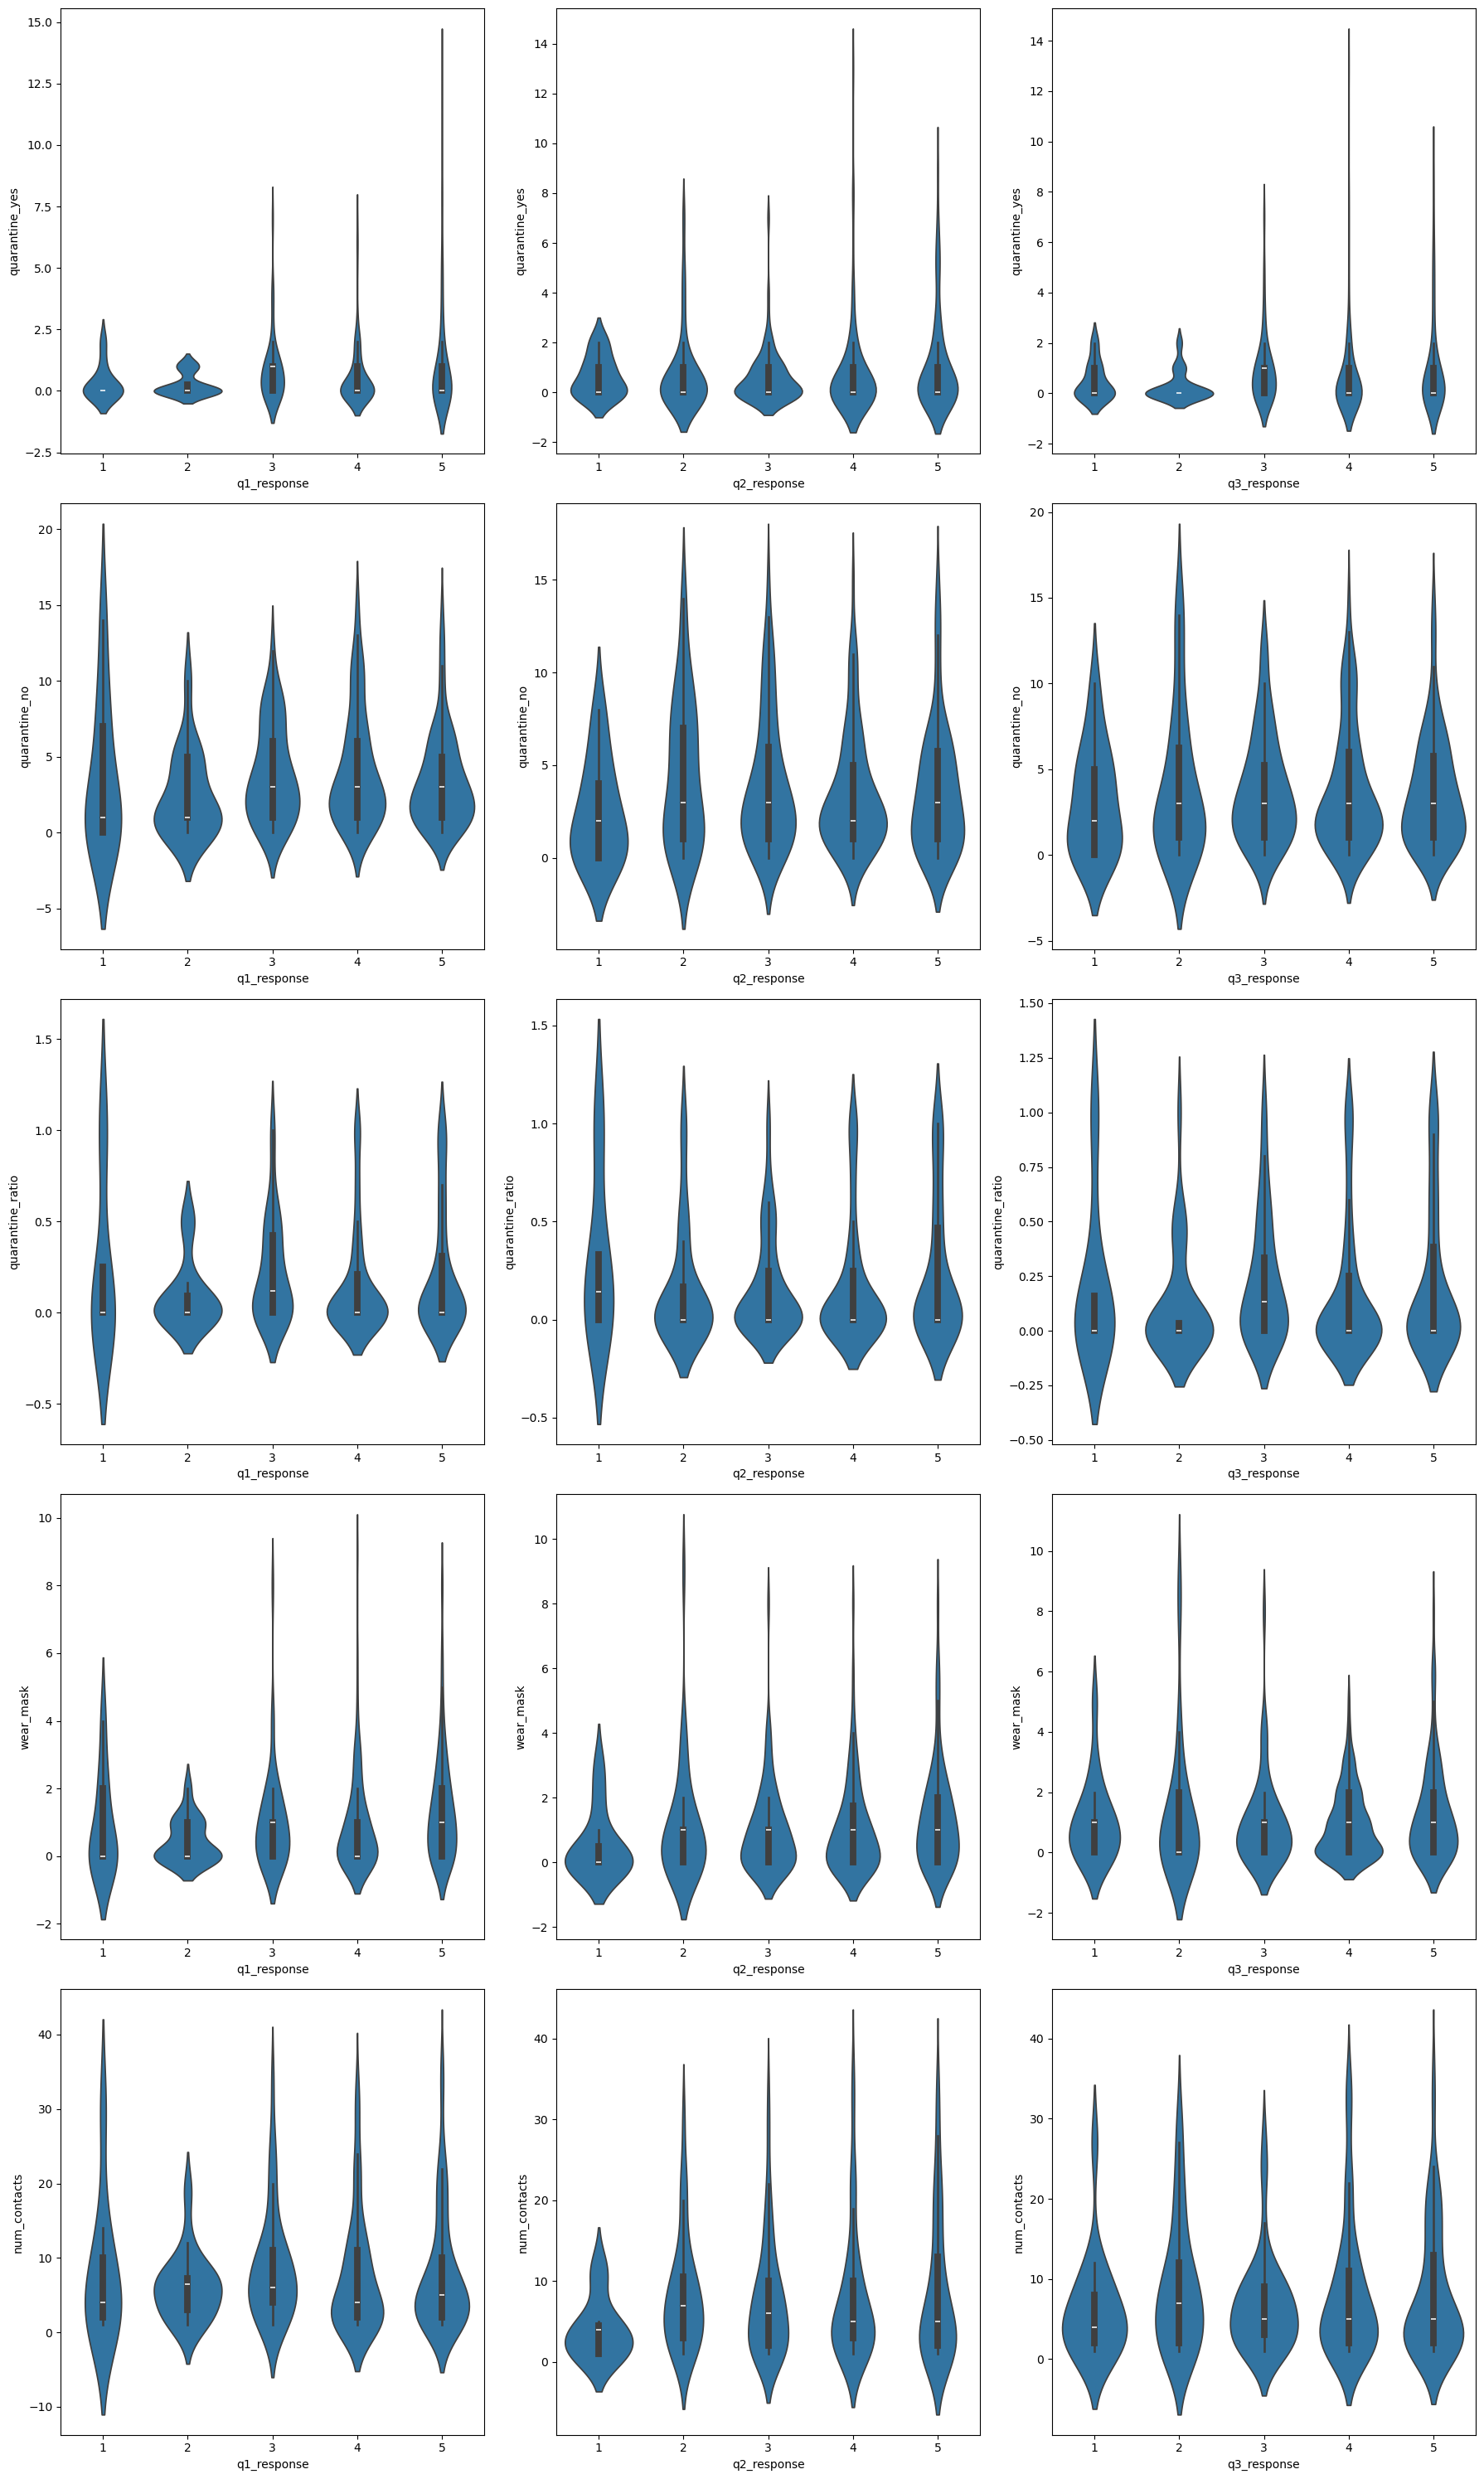

In [28]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=[18, 30])
for avar in action_vars:
    for dvar in demo_vars:    
        axis = axs[action_vars.index(avar), demo_vars.index(dvar)]
        sns.violinplot(x=dvar, y=avar, data=user_prefs, ax=axis)
        axis.set_xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])

fig.tight_layout()
plt.show()

In [29]:
# Significance level for Normality Check and Homogeneity of Variances Check. If those fail, then
# Kruskal-Wallis Test is used because is a a non-parametric alternative to one-way ANOVA and that 
# can be applied when the assumptions of ANOVA (normality and homogeneity of variances) are not met.
sig_level = 0.05

for avar in action_vars:
    for dvar in demo_vars:
        print(avar, 'AND', dvar)
        
        group1 = user_prefs[user_prefs[dvar] == 1][avar]
        group2 = user_prefs[user_prefs[dvar] == 2][avar]
        group3 = user_prefs[user_prefs[dvar] == 3][avar]
        group4 = user_prefs[user_prefs[dvar] == 4][avar]
        group5 = user_prefs[user_prefs[dvar] == 5][avar]

        # Normality check
        _, pnorm1 = stats.shapiro(group1)
        _, pnorm2 = stats.shapiro(group2)
        _, pnorm3 = stats.shapiro(group3)
        _, pnorm4 = stats.shapiro(group4)
        _, pnorm5 = stats.shapiro(group5)
        
        # Homogeneity of variances check
        _, phom = stats.levene(group1, group2, group3, group4, group5)

        anova_assumptions_valid = pnorm1 > sig_level and pnorm2 > sig_level and pnorm3 > sig_level and pnorm4 > sig_level and pnorm5 > sig_level and phom > sig_level
        if anova_assumptions_valid:
            f_statistic, p_value_fstat = stats.f_oneway(group1, group2, group3, group4, group5)    
            print(f'  Statistic for one-way ANOVA Test = {f_statistic:.2f} (p-value = {p_value_fstat:.2f})')
        else:
            h_statistic, p_value_hstat = stats.kruskal(group1, group2, group3, group4, group5)
            print(f'  Statistic for Kruskal-Wallis Test = {h_statistic:.2f} (p-value = {p_value_hstat:.2f})')

quarantine_yes AND q1_response
  Statistic for Kruskal-Wallis Test = 7.46 (p-value = 0.11)
quarantine_yes AND q2_response
  Statistic for Kruskal-Wallis Test = 2.44 (p-value = 0.66)
quarantine_yes AND q3_response
  Statistic for Kruskal-Wallis Test = 10.97 (p-value = 0.03)
quarantine_no AND q1_response
  Statistic for Kruskal-Wallis Test = 5.97 (p-value = 0.20)
quarantine_no AND q2_response
  Statistic for Kruskal-Wallis Test = 3.62 (p-value = 0.46)
quarantine_no AND q3_response
  Statistic for Kruskal-Wallis Test = 1.12 (p-value = 0.89)
quarantine_ratio AND q1_response
  Statistic for Kruskal-Wallis Test = nan (p-value = nan)
quarantine_ratio AND q2_response
  Statistic for Kruskal-Wallis Test = nan (p-value = nan)
quarantine_ratio AND q3_response
  Statistic for Kruskal-Wallis Test = nan (p-value = nan)
wear_mask AND q1_response
  Statistic for Kruskal-Wallis Test = 13.77 (p-value = 0.01)
wear_mask AND q2_response
  Statistic for Kruskal-Wallis Test = 6.55 (p-value = 0.16)
wear_mask 

In [30]:
corr = user_prefs.corr(method='kendall')
corr

,quarantine_yes,quarantine_no,quarantine_ratio,wear_mask,q1_response,q2_response,q3_response,num_contacts
quarantine_yes,1.000000,-0.090407,0.889022,0.144433,0.044068,0.030571,0.036627,0.153875
quarantine_no,-0.090407,1.000000,-0.321211,0.098045,-0.000483,-0.027932,0.011535,0.122205
quarantine_ratio,0.889022,-0.321211,1.000000,0.083481,0.013169,0.018466,0.011537,0.087091
wear_mask,0.144433,0.098045,0.083481,1.000000,0.162820,0.105763,0.071574,0.086395
q1_response,0.044068,-0.000483,0.013169,0.162820,1.000000,0.595367,0.475550,-0.014648
q2_response,0.030571,-0.027932,0.018466,0.105763,0.595367,1.000000,0.485052,-0.003223
q3_response,0.036627,0.011535,0.011537,0.071574,0.475550,0.485052,1.000000,0.002422
num_contacts,0.153875,0.122205,0.087091,0.086395,-0.014648,-0.003223,0.002422,1.000000


## Assortativity with node properties

In [31]:
def get_attrib_data(G, attrib_name):
    data = []
    for n, m, d in G.edges(data=True):
        rn = G.nodes[n][attrib_name]
        rm = G.nodes[m][attrib_name]
        w = d['weight']
        if not np.isnan(rn) and not np.isnan(rm):
            data.append([rn, rm, w])
    return np.array(data)

def calc_weighted_attrib_assortativity(G, attrib):
    data = get_attrib_data(G, attrib)
    wdata = DescrStatsW(data[:,0:2], weights=data[:,2])
    return wdata.corrcoef[0, 1]

def calc_weighted_attrib_assortativity_sig(G, attrib, rho, n_boot=1000):
    data = get_attrib_data(G, attrib)
    p_value = 0.0
    for bootstrap in range(n_boot):
        rho_boot = 0
        xy = np.random.choice(data[:,0:2].flatten(), size=(data.shape[0], 2))
        ww = np.random.choice(data[:,2], size=data.shape[0])
        wdata = DescrStatsW(xy, weights=ww)
        rho_boot = wdata.corrcoef[0, 1]
        if rho_boot >= rho:
            p_value += 1
    p_value /= n_boot
    return p_value

def calc_weighted_assortativity(data, calc_pval=False, n_boot=100):
    W = np.sum(data[:,2])
    
    Xbar = 0
    Ybar = 0
    Xsig = 0
    Ysig = 0
    for row in range(data.shape[0]):
        Xbar += data[row,0]*data[row,2]/W
        Ybar += data[row,1]*data[row,2]/W
    for row in range(data.shape[0]):
        Xsig += data[row,2]*(data[row,0]-Xbar)**2/W
        Ysig += data[row,2]*(data[row,1]-Ybar)**2/W
    Xsig = np.sqrt(Xsig)
    Ysig = np.sqrt(Ysig)

    rho = 0
    for row in range(data.shape[0]):
        rho +=data[row,2]*(data[row,0]-Xbar)*(data[row,1]-Ybar)
        rho /= W*Xsig*Ysig

    if calc_pval:
        p_value = 0.0
        Xbar_boot = np.mean(data[:,0])
        Xsig_boot = np.std(data[:,0])
        for bootstrap in range(n_boot):
            rho_boot = 0
            for row in range(data.shape[0]):
                x = np.random.choice(data[:,0])
                y = np.random.choice(data[:,1])
                w = np.random.choice(data[:,2])
                rho_boot += w*(x-Xbar_boot)*(y-Xbar_boot)
                rho_boot /= W*Xsig_boot**2
            if rho_boot >= rho:
                p_value += 1
                # print(p_value/(bootstrap+1))
        p_value /= n_boot
        return rho, p_value
    
    return rho, None

In [49]:
# Assortativity calculation using the DescrStatsW from statsmodels.stats.weightstats
# and the p-value using bootstrapping
for attrib in attribs: 
    rho = calc_weighted_attrib_assortativity(G, attrib)
    pval = calc_weighted_attrib_assortativity_sig(G, attrib, rho, 1000)
    print(f'Assortativity value for {attrib} = {rho:.2f} (p-value = {pval:.2f})')

Assortativity value for quarantine_yes = 0.10 (p-value = 0.20)
Assortativity value for quarantine_no = 0.17 (p-value = 0.18)
Assortativity value for quarantine_ratio = 0.15 (p-value = 0.12)
Assortativity value for wear_mask = 0.23 (p-value = 0.08)
Assortativity value for num_contacts = 0.31 (p-value = 0.04)
Assortativity value for q1_response = 0.14 (p-value = 0.21)
Assortativity value for q2_response = 0.36 (p-value = 0.05)
Assortativity value for q3_response = 0.25 (p-value = 0.12)


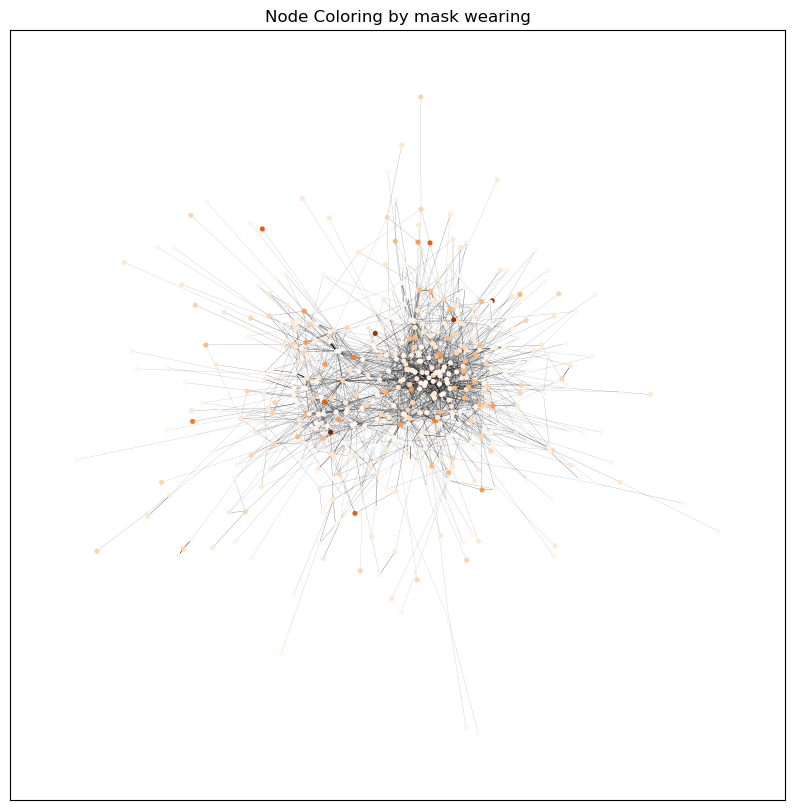

In [33]:
wm_attrib = [wm_dict[idx] for idx in wm_dict]
color_graph_by_attribute(G, Gpos, wm_attrib, 'Node Coloring by mask wearing')

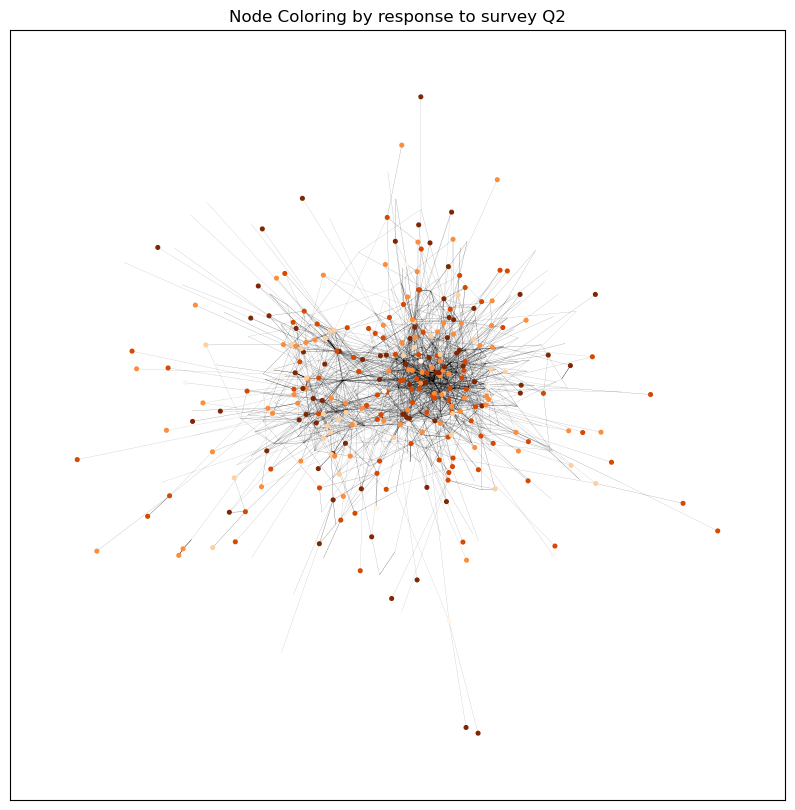

In [34]:
#[val for k, val in qy_dict]
q2_attrib = [q2_dict[idx] for idx in q2_dict]
color_graph_by_attribute(G, Gpos, q2_attrib, 'Node Coloring by response to survey Q2')

## Analysis of super spreader events

This follows the paper "An open-access database of infectious disease transmission trees to explore superspreader epidemiology":

https://github.com/DrakeLab/taube-transmission-trees
https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001685

In [35]:
# Construct a new graph using only the transmission (infection) data
T = nx.DiGraph(infections)

components = nx.weakly_connected_components(T)

subgraphs = [T.subgraph(c) for c in components]
for sg in subgraphs:
    print(len(sg.nodes()), len(sg.edges()))

# Calculate the largest connected component subgraph:
T = sorted(subgraphs, key=lambda x: len(x))[-1]

262 261
40 39
18 17
7 6
2 1


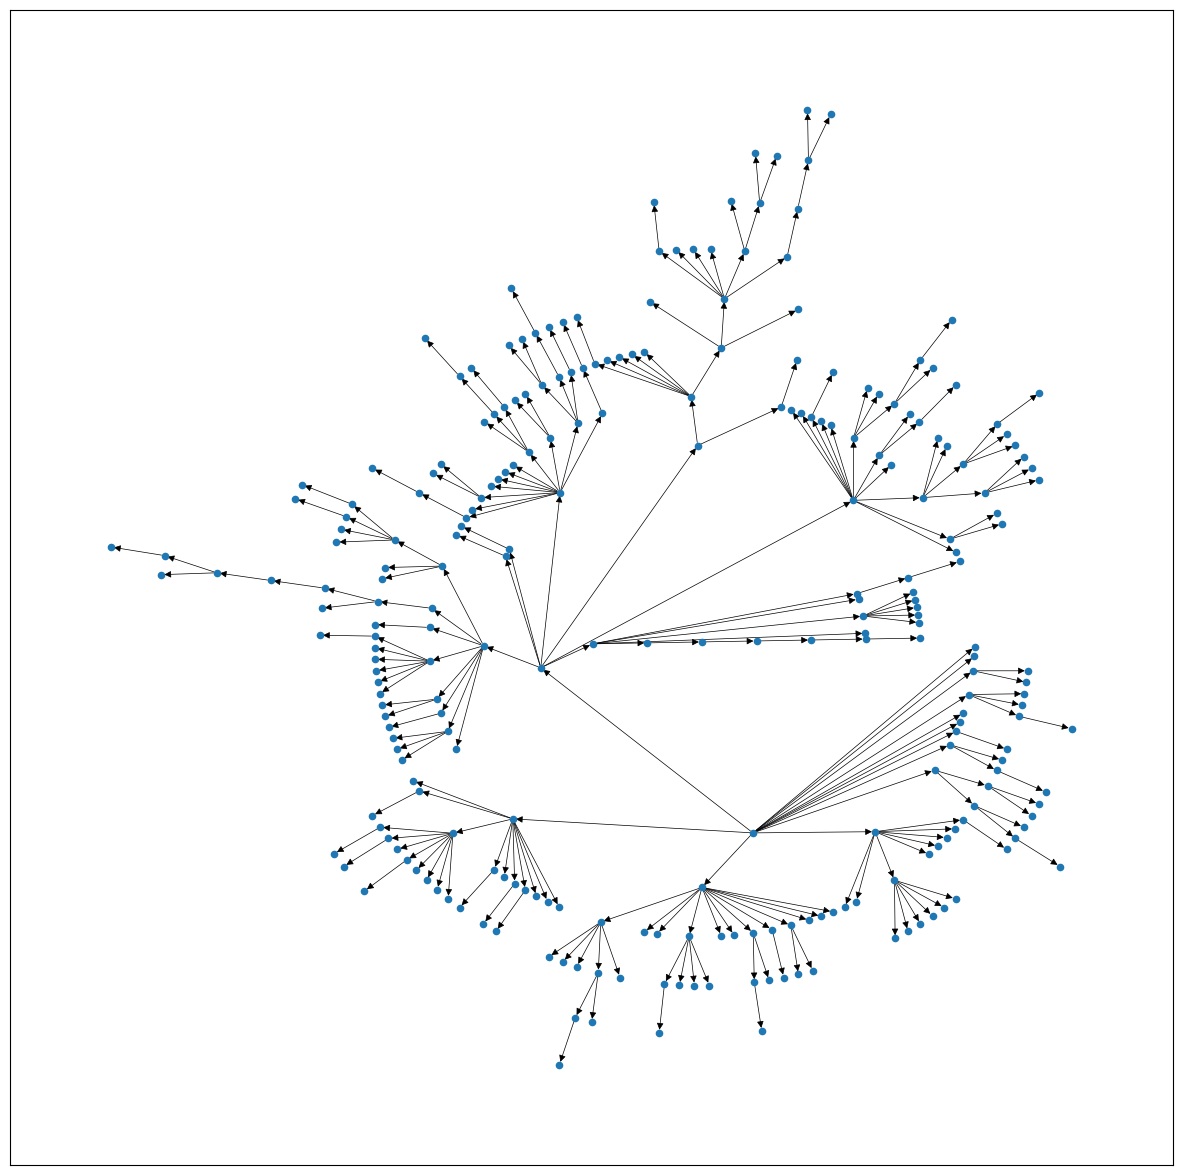

In [36]:
# program = 'dot'    # It arranges nodes hierarchically, often producing a tree-like or layered structure
# program = 'neato'  # Neato attempts to minimize a global energy function, which tends to spread the graph out evenly
# program = 'fdp'    # fdp is a force-directed layout algorithm that simulates physical forces acting on the nodes
# program = 'sfdp'   # sfdp is an extension of fdp designed to handle large graphs by using a multiscale approach
program = 'twopi' # twopi arranges nodes in concentric circles, with edges drawn as spokes connecting the circles
# program ='circo'   # circo arranges nodes in a circular layout, with edges drawn as arcs

pos = nx.nx_agraph.graphviz_layout(T, prog=program)
plt.figure(figsize=(15, 15))
nx.draw_networkx(T, pos, with_labels=False, node_size=20, width=0.5, alpha=1)
plt.show()

In [37]:
# Utility functions

def fit_nbinom0(data):
    """Fit a negative binomial distribution to data and return the size parameter."""
    mean = np.mean(data)
    variance = np.var(data)
    if variance > mean:
        # Estimate the parameters for the negative binomial
        p = mean / variance
        r = mean * p / (1 - p)
        return {"size": r}
    else:
        return {"size": np.nan}

def fit_nbinom(data, summary=False):
    # https://anton-granik.medium.com/fitting-and-visualizing-a-negative-binomial-distribution-in-python-3cc27fbc7ecf
    res = sm.NegativeBinomial(data, np.ones_like(data)).fit(start_params=[1,1])
    if summary: print(res.summary())
    return res.params

def get_nbinom_size(params):
    mu = np.exp(params[0])
    p = 1 / (1 + mu * params[1])
    n = np.min([100, mu * p/(1-p)]) # NOTE: The fitting does not work for second half degrees... 
    return n

def plot_nbinom_fit(data, params):
    mu = np.exp(params[0])
    p = 1 / (1 + mu * params[1])
    n = mu * p/(1-p)
    x = np.linspace(0, max(data), max(data)+1)    
    ax = sns.distplot(data, kde = False, norm_hist=True, label='Real values')
    ax.plot(x, nbinom.pmf(x, n, p), 'g-', lw=2, label='Fitted NB')
    leg = ax.legend()
    plt.title('Real vs Fitted NB Dist')

In [38]:
# Returns super-spreader for a given tree
def ss_stats_per_tree(tree, ss_threshold, root, id):
    # Convert tree node labels to string, assuming they might not be
    tree = nx.relabel_nodes(tree, {node: str(node) for node in tree.nodes()})
    root = str(root)  # Ensure root is a string to match node labels

    names_ss = [node for node, out_degree in tree.out_degree() if out_degree > ss_threshold]

    ss_success_rate_num = ss_success_rate_denom = case_success_rate_num = case_success_rate_denom = 0
    infectors_ris = []
    non_infectors_ris = []

    # first check if tree has superspreaders
    if len(names_ss) == 0:
         # success rates irrelevant here since no superspreaders
        case_success_rate_num = case_success_rate_denom = ss_success_rate_num = ss_success_rate_denom = None
        for node in tree.nodes:
            non_infectors_ris.append(tree.out_degree(node))
    else:
        # if the tree does have superspreaders:
        names_dir_infected = [] # list of nodes directly infected by ALL superspreaders
        infectors = []          # list of nodes that infected superspreaders 

        for ss in names_ss: # for each superspreader
            # add names of those directly infected by ss to list
            directly_infected = [n for n in tree.neighbors(ss)]
            names_dir_infected.extend(directly_infected)

            # Find the infector of the superspreader, if any
            infector = [node for node in tree.predecessors(ss)]
            if infector:
                # add all infectors of superspreaders in this tree to this list
                infectors.extend(infector)

        # all ppl infected by ss, moved to not inside loop
        ss_success_rate_denom = len(set(names_dir_infected))
        ss_success_rate_num = len([name for name in names_ss if name in names_dir_infected]) # if ss infected by another ss

        # for each node, see if infected by a ss, calculate its out degree, also calculate success rate nums and denoms
        for node in tree.nodes:
            # if is a superspreader
            if node in names_ss:
                if node in infectors: # if infected another superspreader
                    infectors_ris.append(tree.out_degree(node))
                else: # if did not infect another superspreader
                    non_infectors_ris.append(tree.out_degree(node))
            else:
                case_success_rate_denom += tree.out_degree(node)
                if node in infectors: # if infected superspreader
                    case_success_rate_num += 1
                    infectors_ris.append(tree.out_degree(node))
                else: # if did not infect superspreader
                    non_infectors_ris.append(tree.out_degree(node))

    # Calculate success rates, taking care of division by zero
    ss_success_rate = ss_success_rate_num / ss_success_rate_denom if ss_success_rate_denom else None
    case_success_rate = case_success_rate_num / case_success_rate_denom if case_success_rate_denom else None

    # Calculate superspreader dyads metrics
    num_ss = len(names_ss)
    size = tree.number_of_nodes()
    num_terminal = sum(1 for _, out_degree in tree.out_degree() if out_degree == 0)
    observed_ss_dyads = ss_success_rate_num if ss_success_rate_num is not None else 0
    expected_ss_dyads = (num_ss * (num_ss - 1)) / size
    expected_ss_dyads_nt = (num_ss * (num_ss - 1)) / (size - num_terminal) if (size - num_terminal) else 0
    excess_ss_dyads = observed_ss_dyads - expected_ss_dyads
    excess_ss_dyads_nt = observed_ss_dyads - expected_ss_dyads_nt

    output = {
        "SS Success Rate": ss_success_rate,
        "Case Success Rate": case_success_rate,
        "Obs SS Dyads": observed_ss_dyads,
        "Exp SS Dyads": expected_ss_dyads,
        "Excess SS Dyads": excess_ss_dyads,
        "Exp SS Dyads JLS": expected_ss_dyads_nt,
        "Excess SS Dyads JLS": excess_ss_dyads_nt,
        "Infectors Ris": infectors_ris,
        "Non-Infectors Ris": non_infectors_ris
    }

    return output

# Determines average out degree of nodes infected vs not infected by a superspreader, as well as success rate
def inf_by_ss_info(tree, thresh, thresh_nt, thresh_nlt, thresh_g01, thresh_g01_nt):
    # Ensure the tree is correctly prepared for processing
    #tree = nx.relabel_nodes(tree, {node: str(node) for node in tree.nodes()})
    root = [n for n, d in tree.in_degree() if d == 0][0]  # Identifying the root node
    
    # Main statistics calculation for different thresholds
    all_nodes = ss_stats_per_tree(tree, thresh, root, id)
    noterm_nodes = ss_stats_per_tree(tree, thresh_nt, root, id)
    nolastterm_nodes = ss_stats_per_tree(tree, thresh_nlt, root, id)
    g01_nodes = ss_stats_per_tree(tree, thresh_g01, root, id)
    noterm_g01_nodes = ss_stats_per_tree(tree, thresh_g01_nt, root, id)

    # Packaging the results into a single dictionary
    bound_output = {
        "all_nodes": all_nodes,
        "noterm_nodes": noterm_nodes,
        "nolastterm_nodes": nolastterm_nodes,
        "g01_nodes": g01_nodes,
        "noterm_g01_nodes": noterm_g01_nodes
    }

    return bound_output

# Gives the ss stats for the first and second halves of the tree
def gen_halves_stats(tree, n_reps=10):
    root = [n for n, d in tree.in_degree() if d == 0][0]
    gens = np.max(list(nx.single_source_shortest_path_length(tree, root).values()))
    output_all = []

    # do this nrepeats times to account for stochasticity
    for rep in range(n_reps):
        distances = nx.single_source_shortest_path_length(tree, root)
        first_nodes = [node for node, distance in distances.items() if distance < gens / 2]
        second_nodes = [node for node, distance in distances.items() if distance > gens / 2]
        middle_nodes = [node for node, distance in distances.items() if distance == gens / 2]

        # randomly assign nodes to first and second halves
        if middle_nodes:
            random_nums = np.random.uniform(size=len(middle_nodes))
            for i, node in enumerate(middle_nodes):
                if random_nums[i] <= 0.5:
                    first_nodes.append(node)
                else:
                    second_nodes.append(node)

        # Calculate statistics for first and second halves
        def calc_stats(nodes):            
            out_degrees = [tree.out_degree(node) for node in nodes]
            out_degrees_nt = [deg for deg in out_degrees if deg > 0]

            # all
            r_a = np.mean(out_degrees)
            thresh_a = poisson.ppf(0.99, r_a)
            dp_a = get_nbinom_size(fit_nbinom(out_degrees))
            num_ss_a = len([deg for deg in out_degrees if deg > thresh])
            ss_freq_a = num_ss_a / len(nodes) if nodes else 0
            
            # no term
            r_nt = np.mean(out_degrees_nt)
            thresh_nt = poisson.ppf(0.99, r_nt)
            dp_nt = get_nbinom_size(fit_nbinom(out_degrees_nt))
            num_ss_nt = len([deg for deg in out_degrees_nt if deg > thresh_nt])
            ss_freq_nt = num_ss_nt / len(nodes) if nodes else 0
            
            return r_a, dp_a, ss_freq_a, r_nt, dp_nt, ss_freq_nt

        r_1_a, dp_1_a, ss_freq_1_a, r_1_nt, dp_1_nt, ss_freq_1_nt = calc_stats(first_nodes)
        r_2_a, dp_2_a, ss_freq_2_a, r_2_nt, dp_2_nt, ss_freq_2_nt = calc_stats(second_nodes)

        output = pd.DataFrame({
            'Gens': [gens],
            'R_1': [r_1_a],
            'R_2': [r_2_a],
            'DP_1': [dp_1_a],
            'DP_2': [dp_2_a],
            'SS Freq 1': [ss_freq_1_a],
            'SS Freq 2': [ss_freq_2_a],            
            'R_1_NT': [r_1_nt],
            'R_2_NT': [r_2_nt],
            'DP_1_NT': [dp_1_nt],
            'DP_2_NT': [dp_2_nt],
            'SS Freq 1 NT': [ss_freq_1_nt],
            'SS Freq 2 NT': [ss_freq_2_nt],
            'rep_num': [rep]
        })

        output_all.append(output)

    output_all_df = pd.concat(output_all, ignore_index=True)
    summary_stats = output_all_df.mean().to_frame().T

    return {"summary": summary_stats, "indiv_sims": output_all_df}

def extract_ss_info_all(tree, ss_threshold):
    size = tree.number_of_nodes()
    root = [n for n, d in tree.in_degree() if d == 0][0]  # Identifying the root node
    names_ss = [n for n, d in tree.out_degree() if d > ss_threshold]  # Superspreaders

    # Check if there are superspreaders
    if names_ss:
        num_dir_infected = []
        num_down_infected = []
        ss_dir_infect = []
        num_infector_infected = []

        for ss in names_ss:
            # Directly infected
            num_dir_infected.append(tree.out_degree(ss))
            # Indirectly infected (downstream)
            num_down_infected.append(len(nx.descendants(tree, ss)))
            
            # Infector analysis
            predecessors = list(tree.predecessors(ss))
            if predecessors:
                infector = predecessors[0]
                num_infector_infected.append(tree.out_degree(infector))
                ss_dir_infect.append(infector in names_ss)
            else:
                num_infector_infected.append(None)
                ss_dir_infect.append(None)

        max_down = np.max(num_down_infected)
        output = pd.DataFrame({
            'SS': names_ss,
            'Thresh': ss_threshold,
            'Direct Infected': num_dir_infected,
            'Direct Prop': [n / (size - 1) for n in num_dir_infected],
            'Indiv Downstream': num_down_infected,
            'Indiv Downstream Prop': [n / (size - 1) for n in num_down_infected],
            'Max Downstream Prop': [max_down / (size - 1)] * len(names_ss),
            'Num SS in Tree': [len(names_ss)] * len(names_ss),
            'Directly Infected by SS': ss_dir_infect,
            'Size': [size] * len(names_ss),
            'R Infector': num_infector_infected,
        })
    else:
        output = pd.DataFrame()

    return output

In [39]:
out_degrees = dict(T.out_degree())
root_nodes = [node for node, in_degree in T.in_degree() if in_degree == 0]
noterm_nodes = [node for node, out_degree in T.out_degree() if out_degree > 0]
noterm_degrees = dict(T.out_degree(noterm_nodes))

d = list(out_degrees.values()) # Out degree of all nodes
d_noterm = list(noterm_degrees.values()) # Out degree of nodes that are not terminal

R0_all = np.mean(d)
R0_noterm = np.mean(d_noterm)

print("R0 for all nodes", R0_all)
print("R0 with no terminal nodes", R0_noterm)

R0 for all nodes 0.9961832061068703
R0 with no terminal nodes 2.5588235294117645


In [40]:
# Determine the maximum distance to all vertices from the roots
R0_nolastgen = 0

# Out-degree of vertices not in the last generation
d_nolastgen = []

for root in root_nodes:
    gens = nx.single_source_shortest_path_length(T, root)

    # Exclude vertices in the last generation
    not_last_gen = [node for node, dist in gens.items() if dist < np.max(list(gens.values()))]

    # Calculate the out-degree of vertices not in the last generation
    d_nolastgen = [T.out_degree(node) for node in not_last_gen]

    # Calculate the mean out-degree of vertices not in the last generation
    R0_nolastgen += sum(d_nolastgen) / len(d_nolastgen)

print("R0 with no last generation nodes", R0_nolastgen)

R0 with no last generation nodes 1.0077220077220077


In [41]:
# calculate coefficient of variance, tree size

# Calculate the mean out-degree
mean_out_degree = sum(d for n, d in T.out_degree()) / T.number_of_nodes()

# Calculate the variance of out-degrees
out_degrees = [d for n, d in T.out_degree()]
var_out_degree = sum((d - mean_out_degree) ** 2 for d in out_degrees) / len(out_degrees)

# Calculate the coefficient of variation
tree_cv = mean_out_degree / var_out_degree
tree_sz = T.number_of_nodes()

print("Coefficient of Variation:", tree_cv)
print("Number of nodes:", tree_sz)

Coefficient of Variation: 0.23282862503021773
Number of nodes: 262


In [42]:
dp = get_nbinom_size(fit_nbinom(d))
dp_noterm = get_nbinom_size(fit_nbinom(d_noterm))
dp_nolastgen = get_nbinom_size(fit_nbinom(d_nolastgen))

# If you want to visually chekc the fit use the following
#plot_nbinom_fit(d_nolastgen, fit_nbinom(d_nolastgen))

Optimization terminated successfully.
         Current function value: 1.316952
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.027381
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.326642
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


In [43]:
for root in root_nodes:
    # calculate r0 and dp for generations 0 and 1 for trees with 20+ nodes and 2+ generations of spread    
    gen1 = T.out_degree(root)
    prop_gen1 = gen1/tree_sz

    # Initialize variables
    r0_takeoff = r0_takeoff_noterm = dp_takeoff = dp_takeoff_noterm = np.nan

    # Calculate first generation node degrees
    first_gen_nodes = [node for node, dist in nx.single_source_shortest_path_length(T, root).items() if dist == 1]
    first_gen_degs = [T.out_degree(node) for node in first_gen_nodes]
    first_gen_degs_nt = [deg for deg in first_gen_degs if deg > 0]

    # Calculate r0_takeoff
    r0_takeoff = (gen1 + sum(first_gen_degs)) / (gen1 + 1)

    # Calculate r0_takeoff_noterm
    r0_takeoff_noterm = (gen1 + sum(first_gen_degs_nt)) / (len(first_gen_degs_nt) + 1)

    # Concatenate degrees for fitting
    degrees_all = [gen1] + first_gen_degs
    degrees_nt = [gen1] + first_gen_degs_nt

    print(degrees_all)
    print(degrees_nt)
    
    # Fit negative binomial distribution to degrees
    dp_takeoff = get_nbinom_size(fit_nbinom(degrees_all))
    dp_takeoff_noterm = get_nbinom_size(fit_nbinom(degrees_nt))

    # Calculate thresholds
    thresh = poisson.ppf(0.99, R0_all)  # threshold for root node
    thresh_noterm = poisson.ppf(0.99, R0_noterm)  # threshold for non-terminal nodes
    thresh_nolastterm = poisson.ppf(0.99, R0_nolastgen)  # threshold for non-terminal nodes excluding last generation
    thresh_g01 = poisson.ppf(0.99, r0_takeoff)  # threshold for first generation nodes
    thresh_g01_noterm = poisson.ppf(0.99, r0_takeoff_noterm)  # threshold for non-terminal first generation nodes

    # Count number of second generation nodes that exceed the threshold
    num_ss = len([node for node, deg in T.out_degree() if deg > thresh])
    num_ss_noterm = len([node for node, deg in T.out_degree() if deg > thresh_noterm])
    num_ss_nolastterm = len([node for node, deg in T.out_degree() if deg > thresh_nolastterm])
    num_ss_g01 = len([node for node, deg in T.out_degree() if deg > thresh_g01])
    num_ss_g01_noterm = len([node for node, deg in T.out_degree() if deg > thresh_g01_noterm])
    prop_ss = num_ss/tree_sz

[13, 12, 7, 8, 2, 2, 1, 0, 0, 3, 2, 10, 0, 0]
[13, 12, 7, 8, 2, 2, 1, 3, 2, 10]
Optimization terminated successfully.
         Current function value: 2.544904
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.769658
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


In [44]:
ss_data_list = extract_ss_info_all(T, thresh)
ss_data_list_noterm = extract_ss_info_all(T, thresh_noterm)
ss_data_list_nolastterm = extract_ss_info_all(T, thresh_nolastterm)
ss_data_list_g01 = extract_ss_info_all(T, num_ss_g01)
ss_data_list_g01_noterm = extract_ss_info_all(T, num_ss_g01_noterm)

inf_by_ss_data_list_all = inf_by_ss_info(T, thresh, thresh_noterm, thresh_nolastterm, num_ss_g01, num_ss_g01_noterm)
gen_halves_analysis = gen_halves_stats(T)

Optimization terminated successfully.
         Current function value: 1.405117
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.116643
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.936112
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 1.378832
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 1.405117
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.116643
         Iterations: 6
         Function evaluations: 7
       

In [45]:
gen_halves_list = gen_halves_analysis['summary']
gen_halves_full_sims_list = gen_halves_analysis['indiv_sims']
gen_halves_list

,Gens,R_1,R_2,DP_1,DP_2,SS Freq 1,SS Freq 2,R_1_NT,R_2_NT,DP_1_NT,DP_2_NT,SS Freq 1 NT,SS Freq 2 NT,rep_num
0,9.0,1.148515,0.483333,0.349796,0.912619,0.074257,0.016667,2.829268,1.45,2.426263,100.0,0.039604,0.016667,4.5


In [46]:
print('RESULTS FOR ALL NODES')
print(f"R 1st half = {gen_halves_list['R_1'][0]:.2f}")
print(f"R 2nd half = {gen_halves_list['R_2'][0]:.2f}")
print(f"k 1st half = {gen_halves_list['DP_1'][0]:.2f}")
print(f"k 2nd half = {gen_halves_list['DP_2'][0]:.2f}")
print(f"Percentage of cases causing SS in 1st half = {100 * gen_halves_list['SS Freq 1'][0]:.2f}%")
print(f"Percentage of cases causing SS in 2nd half = {100 * gen_halves_list['SS Freq 2'][0]:.2f}%")
print(f"Observed number of SS dyads = {round(inf_by_ss_data_list_all['all_nodes']['Obs SS Dyads'])}")
print(f"Expected number of SS dyads = {inf_by_ss_data_list_all['all_nodes']['Exp SS Dyads']:.2f}")
ratio = inf_by_ss_data_list_all['all_nodes']['Obs SS Dyads'] / inf_by_ss_data_list_all['all_nodes']['Exp SS Dyads']
print(f"Ratio of observed to expected SS dyads = {ratio:.2f}")

RESULTS FOR ALL NODES
R 1st half = 1.15
R 2nd half = 0.48
k 1st half = 0.35
k 2nd half = 0.91
Percentage of cases causing SS in 1st half = 7.43%
Percentage of cases causing SS in 2nd half = 1.67%
Observed number of SS dyads = 13
Expected number of SS dyads = 0.92
Ratio of observed to expected SS dyads = 14.19


In [47]:
print('RESULTS WITH NO TERMINAL NODES')
print(f"R 1st half = {gen_halves_list['R_1_NT'][0]:.2f}")
print(f"R 2nd half = {gen_halves_list['R_2_NT'][0]:.2f}")
print(f"k 1st half = {gen_halves_list['DP_1_NT'][0]:.2f}")
print(f"k 2nd half = {gen_halves_list['DP_2_NT'][0]:.2f}")
print(f"Percentage of cases causing SS in 1st half = {100 * gen_halves_list['SS Freq 1 NT'][0]:.2f}%")
print(f"Percentage of cases causing SS in 2nd half = {100 * gen_halves_list['SS Freq 2 NT'][0]:.2f}%")
print(f"Observed number of SS dyads = {inf_by_ss_data_list_all['noterm_nodes']['Obs SS Dyads']}")
print(f"Expected number of SS dyads = {inf_by_ss_data_list_all['noterm_nodes']['Exp SS Dyads']:.2f}")
ratio = inf_by_ss_data_list_all['noterm_nodes']['Obs SS Dyads'] / inf_by_ss_data_list_all['noterm_nodes']['Exp SS Dyads']
print(f"Ratio of observed to expected SS dyads = {ratio:.2f}")

RESULTS WITH NO TERMINAL NODES
R 1st half = 2.83
R 2nd half = 1.45
k 1st half = 2.43
k 2nd half = 100.00
Percentage of cases causing SS in 1st half = 3.96%
Percentage of cases causing SS in 2nd half = 1.67%
Observed number of SS dyads = 4
Expected number of SS dyads = 0.21
Ratio of observed to expected SS dyads = 18.71


## Save daily matrices for factorization analysis

In [48]:
# Generate the state of all nodes in G for each frame of the animation

if obs_date0 and obs_date1:
    tmin = datetime.timestamp(obs_date0)
    tmax = datetime.timestamp(obs_date1)
else:
    tmin = min_time
    tmax = max_time

# Time delta for plots in seconds
daily_delta_sec = 60 * (60 * 24)

t = tmin
frame = 0

tstate = None
print('Calculating the network for each day of the sim...')
nodes0 = list(G.nodes()) # We only look at the nodes we already selected before (which have enough interactions over the entire period of the sim)
allgs = np.zeros((15, len(nodes0), len(nodes0)))
while t <= tmax:
    t0 = t
    t += daily_delta_sec
    td = datetime.fromtimestamp(t, tz=timezone)
    print('Frame', frame+1, datetime.fromtimestamp(t0, tz=timezone).strftime('%Y-%m-%d %H:%M'), 'to', td.strftime('%Y-%m-%d %H:%M'))
    
    # We want to include contact and infection events that either started or ended between t0 and t
    condition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    tevents = events[condition]
    tstate = get_node_state(tevents, tstate)
    tinf = get_infection_list(tevents)
    tcontacts = get_contact_list(tevents, tinf)

    tg = nx.Graph()
    tg.add_nodes_from(nodes0)
    tedges = []
    tweights = []
    if 0 < len(tcontacts):
        for p in tcontacts:
            n0 = p[0]
            n1 = p[1]
            w = tcontacts[p]            
            if n0 in nodes0 and n1 in nodes0 and 0 < w:
                tedges += [(n0, n1)]
                tweights += [w]

    tg.add_weighted_edges_from([(tedges[i][0], tedges[i][1], tweights[i]) for i in range(len(tedges))])
    adjm = nx.adjacency_matrix(tg).todense()
    allgs[frame, :, :] = adjm
    
    frame += 1
print('Done')

np.save(path.join(data_folder, 'daily-contact-matrices.npy'), allgs)
print(f'Saved {frame} adjacency matrices to a Pickle file.')

Calculating the network for each day of the sim...
Frame 1 2023-11-20 09:00 to 2023-11-21 09:00
Frame 2 2023-11-21 09:00 to 2023-11-22 09:00
Frame 3 2023-11-22 09:00 to 2023-11-23 09:00
Frame 4 2023-11-23 09:00 to 2023-11-24 09:00
Frame 5 2023-11-24 09:00 to 2023-11-25 09:00
Frame 6 2023-11-25 09:00 to 2023-11-26 09:00
Frame 7 2023-11-26 09:00 to 2023-11-27 09:00
Frame 8 2023-11-27 09:00 to 2023-11-28 09:00
Frame 9 2023-11-28 09:00 to 2023-11-29 09:00
Frame 10 2023-11-29 09:00 to 2023-11-30 09:00
Frame 11 2023-11-30 09:00 to 2023-12-01 09:00
Frame 12 2023-12-01 09:00 to 2023-12-02 09:00
Frame 13 2023-12-02 09:00 to 2023-12-03 09:00
Frame 14 2023-12-03 09:00 to 2023-12-04 09:00
Frame 15 2023-12-04 09:00 to 2023-12-05 09:00
Done
Saved 15 adjacency matrices to a Pickle file.
